In [4]:
# Installing packages for optim
# Muon
!git clone https://github.com/KellerJordan/Muon.git
!pip install -e Muon
# SOAP
!git clone https://github.com/nikhilvyas/SOAP.git
# Shampoo
!git config core.sparseCheckout true
!git clone --filter=blob:none --no-checkout https://github.com/google-research/google-research/  google_research
%cd google_research/
!git sparse-checkout set --cone
!git checkout master
!git sparse-checkout set scalable_shampoo
!pip install -r scalable_shampoo/requirements.txt
%cd ..

import os, sys
sys.path.append(os.path.join(os.getcwd(),"google_research/scalable_shampoo/pytorch"))

fatal: destination path 'Muon' already exists and is not an empty directory.
Obtaining file:///home/afafelwafi/Courses/Pytorch/Muon
  Preparing metadata (setup.py) ... done
  Attempting uninstall: muon
    Found existing installation: muon 0.1.0
    Uninstalling muon-0.1.0:
      Successfully uninstalled muon-0.1.0
  DEPRECATION: Legacy editable install of muon==0.1.0 from file:///home/afafelwafi/Courses/Pytorch/Muon (setup.py develop) is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for muon
fatal: destination path 'SOAP' already exists and is not an empty directory.
fatal: not in a git directory
fatal: destina

In [ ]:
import math
import torch
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from google_research.scalable_shampoo.pytorch.shampoo import Shampoo
from muon import Muon
from SOAP.soap import SOAP

from typing import Dict, Any

In [13]:
# for distributed Muon (this is on one GPU)
import torch.distributed as dist

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backend = 'nccl' if torch.cuda.is_available() else 'gloo'


# Set necessary environment variables
os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"
os.environ["MASTER_ADDR"] = "127.0.0.1"
os.environ["MASTER_PORT"] = "29500"

# Initialize the process group
if not dist.is_initialized():
    dist.init_process_group(backend=backend, init_method="env://")




In [ ]:
import torch
from typing import Union

def rosenbrock(x: float, y: float, a: float = 1, b: float = 100) -> float:
    """
    Computes the Rosenbrock function value for given x and y.
    
    Parameters:
        x (float): The x-coordinate.
        y (float): The y-coordinate.
        a (float, optional): Constant parameter, default is 1.
        b (float, optional): Constant parameter, default is 100.
    
    Returns:
        float: The computed Rosenbrock function value.
    """
    return (a - x) ** 2 + b * (y - x**2) ** 2

def torch_rosenbrock(params: Union[torch.Tensor, list], a: float = 1, b: float = 100) -> torch.Tensor:
    """
    Computes the Rosenbrock function value for given parameters in a PyTorch-compatible form.
    
    Parameters:
        params (Union[torch.Tensor, list]): A tensor or list containing x and y values.
        a (float, optional): Constant parameter, default is 1.
        b (float, optional): Constant parameter, default is 100.
    
    Returns:
        torch.Tensor: The computed Rosenbrock function value as a PyTorch tensor.
    """
    try:
        x, y = params
        return (a - x) ** 2 + b * (y - x**2) ** 2
    except Exception as e:
        raise ValueError(f"Invalid input for torch_rosenbrock: {e}")


In [15]:
##### Code from repo https://github.com/nanowell/AdEMAMix-Optimizer-Pytorch/blob/main/AdEMAMix.py

class AdEMAMix(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999, 0.9999), eps=1e-8,
                 weight_decay=0, alpha=5.0, T_alpha_beta3=None):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        assert len(betas) == 3, f"Invalid beta parameters: {betas}, expected 3"
        assert all(0.0 <= beta < 1.0 for beta in betas), f"Invalid beta parameters: {betas}"
        if not 0.0 <= weight_decay:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")
        
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay,
                        alpha=alpha, T_alpha_beta3=T_alpha_beta3)
        super(AdEMAMix, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdEMAMix, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            exp_avg_slow = []
            state_steps = []

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('AdEMAMix does not support sparse gradients')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = 0
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Slow exponential moving average
                        state['exp_avg_slow'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])
                    exp_avg_slow.append(state['exp_avg_slow'])
                    state['step'] += 1
                    state_steps.append(state['step'])

            beta1, beta2, beta3 = group['betas']
            alpha = group['alpha']
            T_alpha_beta3 = group['T_alpha_beta3']

            self._update_adamemix(
                params_with_grad,
                grads,
                exp_avgs,
                exp_avg_sqs,
                exp_avg_slow,
                state_steps,
                beta1=beta1,
                beta2=beta2,
                beta3=beta3,
                alpha=alpha,
                T_alpha_beta3=T_alpha_beta3,
                lr=group['lr'],
                weight_decay=group['weight_decay'],
                eps=group['eps'],
            )

        return loss

    def _update_adamemix(self, params, grads, exp_avgs, exp_avg_sqs, exp_avg_slow, state_steps,
                         beta1, beta2, beta3, alpha, T_alpha_beta3, lr, weight_decay, eps):
        
        for i, param in enumerate(params):
            grad = grads[i]
            exp_avg = exp_avgs[i]
            exp_avg_sq = exp_avg_sqs[i]
            exp_avg_slow_i = exp_avg_slow[i]
            step = state_steps[i]

            bias_correction1 = 1 - beta1 ** step
            bias_correction2 = 1 - beta2 ** step

            if T_alpha_beta3 is not None:
                alpha_t = min(step * alpha / T_alpha_beta3, alpha)
                beta3_t = min(math.exp(math.log(beta1) * math.log(beta3) / 
                              ((1 - step / T_alpha_beta3) * math.log(beta3) + 
                               (step / T_alpha_beta3) * math.log(beta1))), beta3)
            else:
                alpha_t = alpha
                beta3_t = beta3

            # Decay the first and second moment running average coefficient
            exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
            exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
            exp_avg_slow_i.mul_(beta3_t).add_(grad, alpha=1 - beta3_t)

            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

            step_size = lr / bias_correction1

            if weight_decay != 0:
                param.add_(param, alpha=-weight_decay * lr)

            param.addcdiv_(exp_avg + alpha_t * exp_avg_slow_i, denom, value=-step_size)


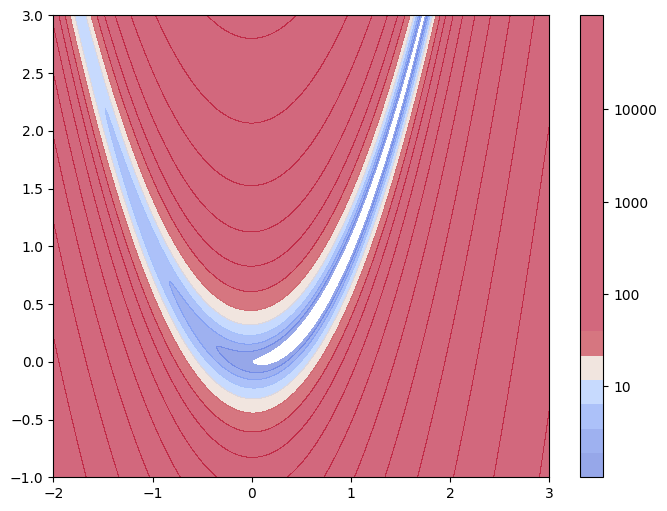

In [ ]:
# Figure setup
fig, ax = plt.subplots(figsize=(8, 6))

# Parameters
epochs = 500

# Initial condition
initial_position = torch.tensor([-1.0, 1.0], dtype=torch.float32, requires_grad=True).to(device)

# Path colors
colors = {
    "AdamW": "yellow", "Shampoo": "green", "SOAP": "aqua", "Muon": "black", "Adagrad": "red",
    "SGD": "orange", "SGDM": "blue", "AdEMAMix": "violet", "NAG": "grey", "RMSprop": "brown"
}

# Define optimizer parameters
try:
    optim_params = {
        optimizer: initial_position.clone().detach().requires_grad_(True)
        if optimizer != "Muon"
        else initial_position.clone().detach().view(-1, 1).requires_grad_(True)
        for optimizer in colors.keys()
    }
except Exception as e:
    raise RuntimeError(f"Error initializing optimizer parameters: {e}")

# Define optimizers
try:
    optimizers  = {
        "Shampoo": Shampoo([optim_params["Shampoo"].to(device)], lr=0.001),
        "AdamW": optim.AdamW([optim_params["AdamW"].to(device)], lr=0.01, weight_decay=0.01),
        "SOAP": SOAP([optim_params["SOAP"].to(device)], lr=0.01),
        "Muon": Muon([optim_params["Muon"].to(device)], lr=0.01, weight_decay=0.01),
        "AdEMAMix": AdEMAMix([optim_params["AdEMAMix"]], lr=0.01, weight_decay=0.01),
        "RMSprop": optim.RMSprop([optim_params["RMSprop"]], lr=0.01, weight_decay=0.01),
        "Adagrad": optim.Adagrad([optim_params["Adagrad"]], lr=0.01, weight_decay=0.01),
        "SGD": optim.SGD([optim_params["SGD"]], lr=0.001, weight_decay=0.01),
        "SGDM": optim.SGD([optim_params["SGDM"]], lr=0.001, momentum=0.9, weight_decay=0.01),
        "NAG": optim.SGD([optim_params["NAG"]], lr=0.001, momentum=0.9, weight_decay=0.01, nesterov=True),
    }
except Exception as e:
    raise RuntimeError(f"Error initializing optimizers: {e}")

# Create meshgrid for contour plot
x = np.linspace(-2, 3, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = (1 - X) ** 2 + 100 * (Y - X**2) ** 2  # Rosenbrock function

# Set the contour
contour = ax.contourf(X, Y, Z, levels=np.logspace(0, 5, 20), cmap='coolwarm', alpha=0.6, vmin=-1, vmax=30)
cbar = plt.colorbar(contour, ticks=[0, 10, 1e2, 1e3, 1e4])

def get_positions(epochs: int, optim_params: Dict[str, torch.Tensor]) -> Dict[str, np.ndarray]:
    """
    Run optimization and store the positions of parameters for visualization.
    """
    positions = {key: [param.cpu().clone().detach().numpy()] for key, param in optim_params.items()}
    
    for t in range(epochs):
        for key, optimizer in optimizers.items():
            try:
                optimizer.zero_grad()
                loss = torch_rosenbrock(optim_params[key])  # Compute loss
                loss.backward()
                optimizer.step()
                positions[key].append(optim_params[key].cpu().clone().detach().numpy())
            except Exception as e:
                print(f"Error during optimization step for {key}: {e}")
    
    return {key: np.array(path) for key, path in positions.items()}

def update(frame: int):
    """
    Update function for animation.
    """
    positions = get_positions(epochs, optim_params)
    ax.clear()
    
    # Redraw contour
    contour = ax.contourf(X, Y, Z, levels=np.logspace(0, 5, 20), cmap='coolwarm', alpha=0.6, vmin=-1, vmax=30)
    
    for key, path_pos in positions.items():
        try:
            ax.plot(path_pos[:frame, 0], path_pos[:frame, 1], color=colors[key], label=f"{key} Path", lw=2)
            ax.scatter(*path_pos[frame], color=colors[key], s=100, zorder=5)
            loss_value = torch_rosenbrock(torch.tensor(path_pos[frame])).item()
            ax.text(path_pos[frame, 0], path_pos[frame, 1], f"{loss_value:.2f}", color=colors[key], fontsize=12, ha='center', va='bottom')
        except Exception as e:
            print(f"Error in animation update for {key}: {e}")
    
    ax.set_xlim(-2, 3)
    ax.set_ylim(-1, 3)
    ax.set_title(r"$f(x, y) = (1 - x)^2 + 100(y - x^2)^2$" + f"\nEpoch {frame}", fontsize=12)
    ax.legend(loc="upper left")
    ax.set_xlabel("x")
    ax.set_ylabel("y")


In [32]:
# Create figure for animation
def animate_and_save_figure(fig,update,epochs,interval,repeat, title,fps)
    ani = FuncAnimation(fig, update, frames=epochs, interval=10, repeat=False)

    # Save animation as a GIF
    ani.save(f'{title}.gif', writer='pillow', fps=15)

KeyboardInterrupt: 